This notebook demonstrates how to optimize the parameters of the state-space model (implemented in **ReactiveMP.jl**) through an external optimization packages such as [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl/)

We use the following model:
$$
\begin{align*}
    \mathbf{x}_t &\sim \mathcal{N}\left(\mathbf{Ax}_{t-1}, \mathbf{Q} \right) \\
    \mathbf{y}_t &\sim \mathcal{N}\left(\mathbf{x}_{t}, \mathbf{P} \right) 
\end{align*}
$$
with prior $$\mathbf{x}_0 \sim \mathcal{N}(\mathbf{m_{{x}_0}}, \mathbf{V_{{x}_0}})$$ and transition matrix $$\mathbf{A} = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$$
Covariance matrices $\mathbf{V_{{x}_0}}$, $\mathbf{P}$ and $\mathbf{Q}$ are known.

Our goal is to optimize parameters $\mathbf{m_{{x}_0}}$ and $\theta$.

In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
using Random

In [2]:
@model function rotate_ssm(n, θ, x0, Q::ConstVariable, P::ConstVariable)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    
    x_prev = x_prior
    
    A = constvar([ cos(θ) -sin(θ); sin(θ) cos(θ) ])
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q) where { q = q(out, mean)q(cov) }
        y[i] ~ MvNormalMeanCovariance(x[i], P) where { q = q(out)q(mean)q(cov) }
        
        x_prev = x[i]
    end
    
    return x, y
end

In [42]:
# Generate data

Random.seed!(1234)

θ = π / 8
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
Q = Matrix(Diagonal(1.0 * ones(2)))
P = Matrix(Diagonal(1.0 * ones(2)))

n = 300

x_prev = [ 10.0, -10.0 ]

x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(A * x_prev, Q))
    y[i] = rand(MvNormal(x[i], Q))
    
    x_prev = x[i]
end

In [4]:
using Plots

In [5]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

slicedim (generic function with 1 method)

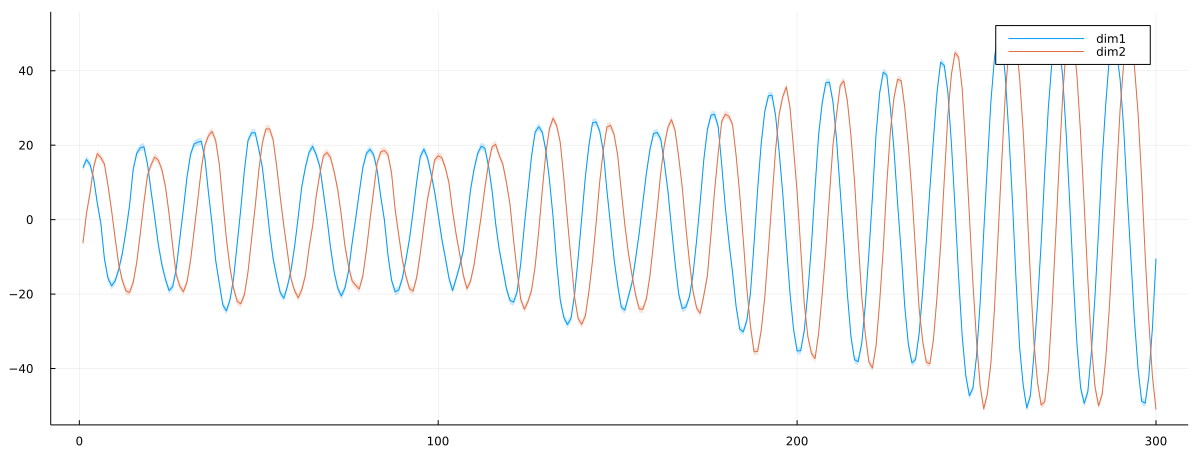

In [6]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")

plot(px, size = (1200, 450))

In [17]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    result = inference(model=Model(rotate_ssm, n, θ[1], x0, Q, P), data=(y=y,), free_energy=true)
    return result.free_energy[end]
end

f (generic function with 1 method)

In [18]:
using Optim

In [19]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true))

Iter     Function value   Gradient norm 
     0     2.192003e+04     9.032537e+04
 * time: 0.00014901161193847656
     1     2.949440e+03     3.212904e+04
 * time: 4.48748517036438
     2     1.237184e+03     1.432789e+02
 * time: 4.857617139816284
     3     1.237151e+03     6.975533e+00
 * time: 5.259435176849365
     4     1.161372e+03     7.271207e-01
 * time: 7.329573154449463
     5     1.161372e+03     6.279436e-04
 * time: 7.705805063247681
     6     1.161372e+03     7.885200e-07
 * time: 8.2765212059021
     7     1.161372e+03     9.387143e-08
 * time: 8.844228029251099


 * Status: success

 * Candidate solution
    Final objective value:     1.161372e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.41e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.27e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-16 ≤ 1.0e-14
    |g(x)|                 = 9.39e-08 ≰ 1.0e-12

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    7
    f(x) calls:    47
    ∇f(x) calls:   47


In [20]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer[1])

Real value vs Optimized
Real:      0.39269908169872414
Optimized: 0.392933248139125


In [21]:
@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

(sin(θ), sin(res.minimizer[1])) = (0.3826834323650898, 0.38289976345258336)
(cos(θ), cos(res.minimizer[1])) = (0.9238795325112867, 0.9237898955649795)


(0.9238795325112867, 0.9237898955649795)

In [52]:
x0 = MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2))))
result = inference(model=Model(rotate_ssm, n, res.minimizer[1], x0, Q, P), data=(y=y,), free_energy=true)
xmarginals = result.posteriors[:x][1];

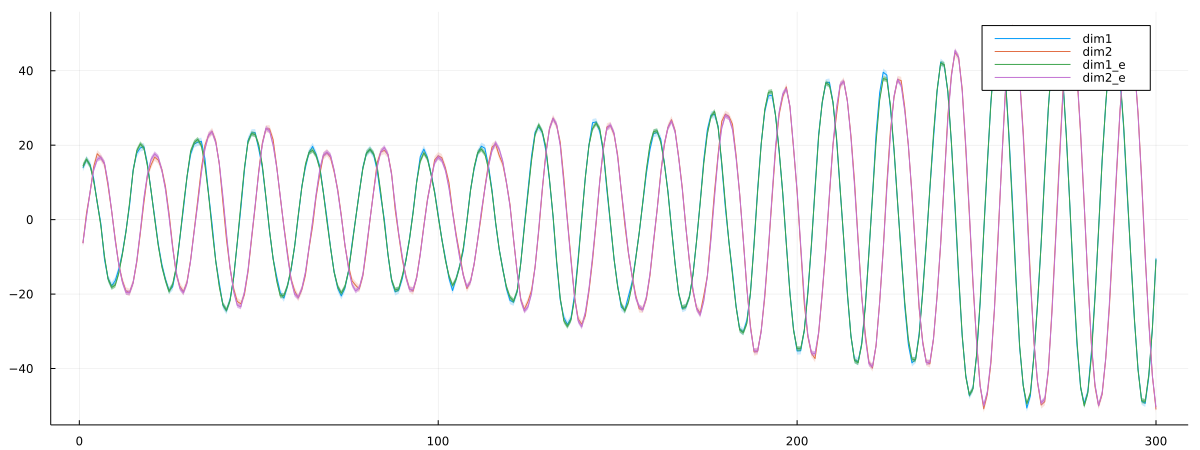

In [53]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")
px = plot!(px, mean.(xmarginals) |> slicedim(1), ribbon = var.(xmarginals) |> slicedim(1) .|> sqrt, fillalpha = 0.5, label = "dim1_e")
px = plot!(px, mean.(xmarginals) |> slicedim(2), ribbon = var.(xmarginals) |> slicedim(2) .|> sqrt, fillalpha = 0.5, label = "dim2_e")

plot(px, size = (1200, 450))